In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import datetime
import time

In [2]:
dataset = pd.read_csv('DGS10.csv')

In [3]:
dataset.rename(columns={'DGS10':'10Y_Rate'},inplace=True) # Change naming convention
dataset.head(5)

,DATE,10Y_Rate
0,1962-01-02,4.06
1,1962-01-03,4.03
2,1962-01-04,3.99
3,1962-01-05,4.02
4,1962-01-08,4.03


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16163 entries, 0 to 16162
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DATE      16163 non-null  object
 1   10Y_Rate  16163 non-null  object
dtypes: object(2)
memory usage: 252.7+ KB


In [5]:
# 'DATE' column is converted from 'object' data type to 'datetime'
dataset["DATE"] = pd.to_datetime(dataset["DATE"])
dataset = dataset.set_index("DATE")
dataset.head()

,10Y_Rate
DATE,
1962-01-02,4.06
1962-01-03,4.03
1962-01-04,3.99
1962-01-05,4.02
1962-01-08,4.03


In [6]:
# convert the values from object to float
dataset = dataset.apply(pd.to_numeric, errors='coerce')
dataset.info()
dataset.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16163 entries, 1962-01-02 to 2023-12-14
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   10Y_Rate  15475 non-null  float64
dtypes: float64(1)
memory usage: 252.5 KB


,10Y_Rate
count,15475.000000
mean,5.872182
std,2.974748
min,0.520000
25%,3.850000
50%,5.620000
75%,7.620000
max,15.840000


In [7]:
dataset.index

DatetimeIndex(['1962-01-02', '1962-01-03', '1962-01-04', '1962-01-05',
               '1962-01-08', '1962-01-09', '1962-01-10', '1962-01-11',
               '1962-01-12', '1962-01-15',
               ...
               '2023-12-01', '2023-12-04', '2023-12-05', '2023-12-06',
               '2023-12-07', '2023-12-08', '2023-12-11', '2023-12-12',
               '2023-12-13', '2023-12-14'],
              dtype='datetime64[ns]', name='DATE', length=16163, freq=None)

In [8]:
first_day = dataset.index.min()
last_day = dataset.index.max()
first_day, last_day

(Timestamp('1962-01-02 00:00:00'), Timestamp('2023-12-14 00:00:00'))

In [9]:
full_range = pd.date_range(start=first_day, end=last_day, freq="D")

full_range.difference(dataset.index)

DatetimeIndex(['1962-01-06', '1962-01-07', '1962-01-13', '1962-01-14',
               '1962-01-20', '1962-01-21', '1962-01-27', '1962-01-28',
               '1962-02-03', '1962-02-04',
               ...
               '2023-11-11', '2023-11-12', '2023-11-18', '2023-11-19',
               '2023-11-25', '2023-11-26', '2023-12-02', '2023-12-03',
               '2023-12-09', '2023-12-10'],
              dtype='datetime64[ns]', length=6464, freq=None)

In [10]:
dataset.isna().sum()  # 6464 days missing, 688 in 10 year column missing, what are they? These can be dropped as they are days where the market is closed for holidays.

10Y_Rate    688
dtype: int64

In [11]:
dataset[dataset.isna().any(axis=1)]

,10Y_Rate
DATE,
1962-02-12,NaN
1962-02-22,NaN
1962-04-20,NaN
1962-05-30,NaN
1962-07-04,NaN
...,...
2023-06-19,NaN
2023-07-04,NaN
2023-09-04,NaN


In [12]:
dataset_cleaned = dataset.dropna()

In [13]:
dataset_cleaned.info(), dataset_cleaned.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15475 entries, 1962-01-02 to 2023-12-14
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   10Y_Rate  15475 non-null  float64
dtypes: float64(1)
memory usage: 241.8 KB


(None,
            10Y_Rate
 count  15475.000000
 mean       5.872182
 std        2.974748
 min        0.520000
 25%        3.850000
 50%        5.620000
 75%        7.620000
 max       15.840000)

In [14]:
file_path = '/content/drive/My Drive/DGS10_clean2.csv'


In [15]:
dataset_cleaned.to_csv(file_path, index=True)

In [16]:
file = "DGS10_clean2.csv"
df = pd.read_csv(file, index_col='DATE', parse_dates=True) #converts date string into datetime object on import
df

,10Y_Rate
DATE,
1962-01-02,4.06
1962-01-03,4.03
1962-01-04,3.99
1962-01-05,4.02
1962-01-08,4.03
...,...
2023-12-08,4.23
2023-12-11,4.23
2023-12-12,4.20


In [17]:
predict_10Y_Rate = df['10Y_Rate']
predict_10Y_Rate # set target variable

DATE
1962-01-02    4.06
1962-01-03    4.03
1962-01-04    3.99
1962-01-05    4.02
1962-01-08    4.03
              ... 
2023-12-08    4.23
2023-12-11    4.23
2023-12-12    4.20
2023-12-13    4.04
2023-12-14    3.92
Name: 10Y_Rate, Length: 15475, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

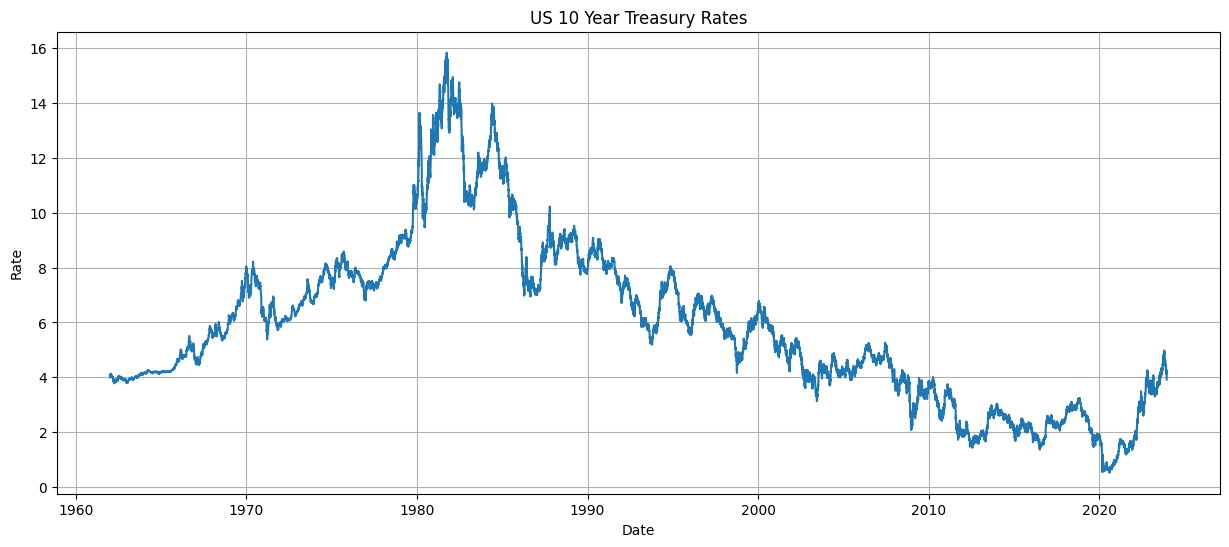

In [18]:
# Plot line chart
plt.figure(figsize=(15,6))
plt.plot(predict_10Y_Rate)
plt.title('US 10 Year Treasury Rates')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.grid(True)
plt.show

In [19]:
# Stationarity test using Augmented Dickey-Fuller
result = adfuller(predict_10Y_Rate)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -1.674784
p-value: 0.444149
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


We can see that the ADF Statistic is greater than the thresholds for critical values of significance, therefore we cannot reject the null-hypothesis. Looking at the results, -1.674784 is greater than the values for critical values 1%, 5%, 10%. We must make the data stationary by differencing.

In [20]:
# Calculate difference
predict_10Y_Rate_diff1 = predict_10Y_Rate.diff() #difference between each element and it's previous
predict_10Y_Rate_diff1.dropna(inplace=True) # NaN value in the first row needs to be dropped from differencing of first element
predict_10Y_Rate_diff1

DATE
1962-01-03   -0.03
1962-01-04   -0.04
1962-01-05    0.03
1962-01-08    0.01
1962-01-09    0.02
              ... 
2023-12-08    0.09
2023-12-11    0.00
2023-12-12   -0.03
2023-12-13   -0.16
2023-12-14   -0.12
Name: 10Y_Rate, Length: 15474, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

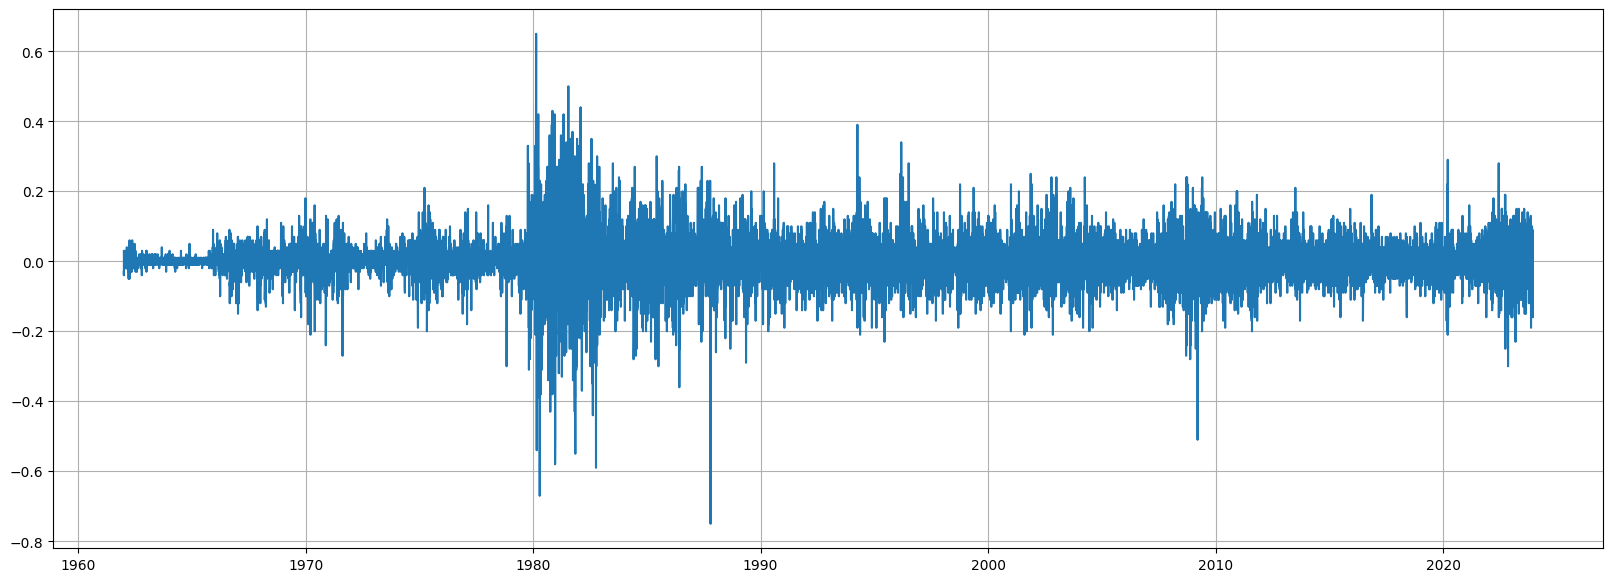

In [21]:
# Plot the series again to observe stationarity
plt.figure(figsize=(20,7))
plt.grid(True)
plt.plot(predict_10Y_Rate_diff1)
plt.show

Results are showing a relatively flat time-series with no clear predictiable trend or seasonality in the long-term. Visually, this appears to be stationary. Let's run the ADF test again to confirm.  

In [22]:
# Run test again after differencing
result = adfuller(predict_10Y_Rate_diff1, regression='ctt')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -19.335725
p-value: 0.000000
Critical Values:
	1%: -4.372
	5%: -3.833
	10%: -3.553


When comparing the ADF value after differencing, there is reason to reject the null hypothesis. The resulting value of -19.335725 is more extreme than the critical value thresholds of significance, therefore the series is likely stationary.

We now move on to plotting the autocorrelation and partial autocorrelation function to determine lag values.

(-0.05, 0.05)

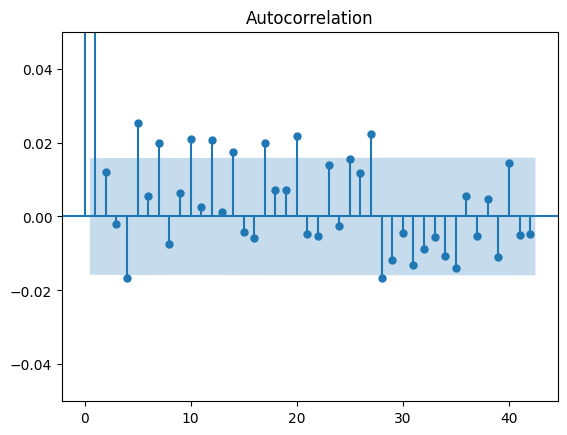

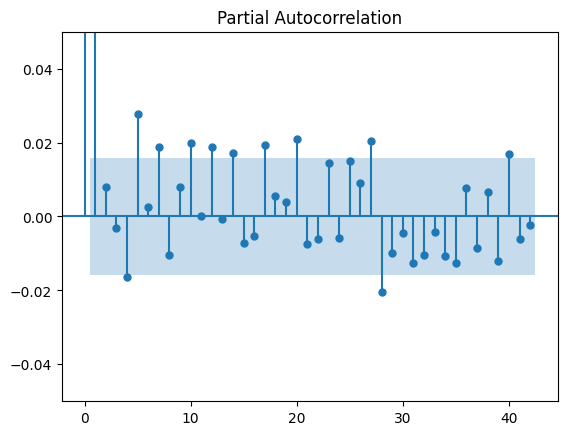

In [23]:
# Plot the autocorrelation and partial autocorrelation
acf = plot_acf(predict_10Y_Rate_diff1)
plt.ylim(-0.05,0.05)
pacf = plot_pacf(predict_10Y_Rate_diff1)
plt.ylim(-0.05,0.05)

There is a significant drop off after a lag of 1 in both the ACF and PACF plots. We can use this as the input parameter AR order of p, MA order of q. Give only a first-order difference was applied, the parameters will be (1,1,1)

In [24]:
# Model the ARIMA process
model = ARIMA(predict_10Y_Rate[:-50], order=(1,1,1), trend='n')
result = model.fit()
result.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               10Y_Rate   No. Observations:                15425
Model:                 ARIMA(1, 1, 1)   Log Likelihood               20258.283
Date:                Sun, 17 Dec 2023   AIC                         -40510.566
Time:                        03:22:19   BIC                         -40487.635
Sample:                             0   HQIC                        -40502.968
                              - 15425                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1785      0.065      2.746      0.006       0.051       0.306
ma.L1         -0.1140      0.066     -1.728      0.084      -0.243       0.015
sigma2         0.0042   2.07e-05    204.125      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             52806.19
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

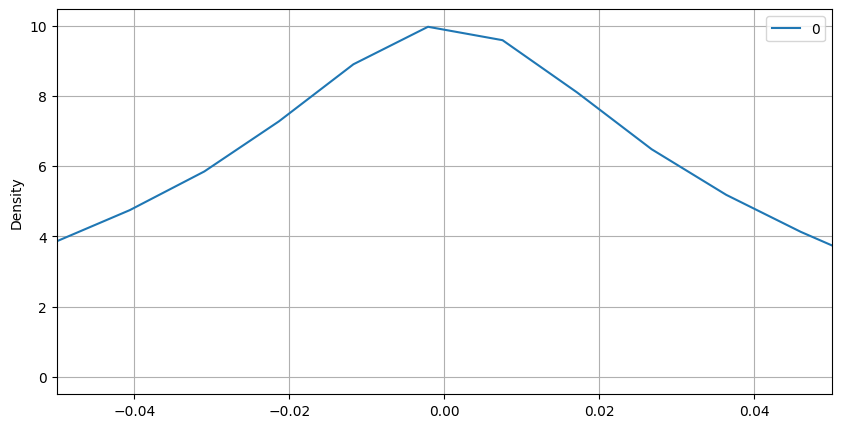

In [25]:
residuals = pd.DataFrame(result.resid)
residuals.plot(kind='kde', figsize=(10,5))
plt.xlim(-0.05,0.05)
plt.grid(True)
plt.show()

Checking the distribution of residuals helps validate normality of the differences. We can see that the plot follows a relatively normal distribution, thus we can move forward with the validation process.

 predicted=4.818466, expected=4.730000 
 predicted=4.725807, expected=4.720000 
 predicted=4.718886, expected=4.780000 
 predicted=4.783733, expected=4.660000 
 predicted=4.652718, expected=4.580000 
 predicted=4.574044, expected=4.700000 
 predicted=4.707057, expected=4.630000 
 predicted=4.626295, expected=4.710000 
 predicted=4.714699, expected=4.830000 
 predicted=4.838211, expected=4.910000 
 predicted=4.916054, expected=4.980000 
 predicted=4.985186, expected=4.930000 
 predicted=4.927370, expected=4.860000 
 predicted=4.855208, expected=4.830000 
 predicted=4.827539, expected=4.950000 
 predicted=4.957442, expected=4.860000 
 predicted=4.855054, expected=4.840000 
 predicted=4.838173, expected=4.880000 
 predicted=4.882363, expected=4.880000 
 predicted=4.880259, expected=4.770000 
 predicted=4.762979, expected=4.670000 
 predicted=4.662816, expected=4.570000 
 predicted=4.562771, expected=4.670000 
 predicted=4.675647, expected=4.580000 
 predicted=4.574854, expected=4.490000 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 predicted=4.336298, expected=4.270000 
 predicted=4.265134, expected=4.370000 
 predicted=4.375801, expected=4.220000 
 predicted=4.211185, expected=4.280000 
 predicted=4.282757, expected=4.180000 
 predicted=4.174036, expected=4.120000 
 predicted=4.115508, expected=4.140000 
 predicted=4.140726, expected=4.230000 
 predicted=4.235757, expected=4.230000 
 predicted=4.230675, expected=4.200000 
 predicted=4.198188, expected=4.040000 
 predicted=4.029697, expected=3.920000 


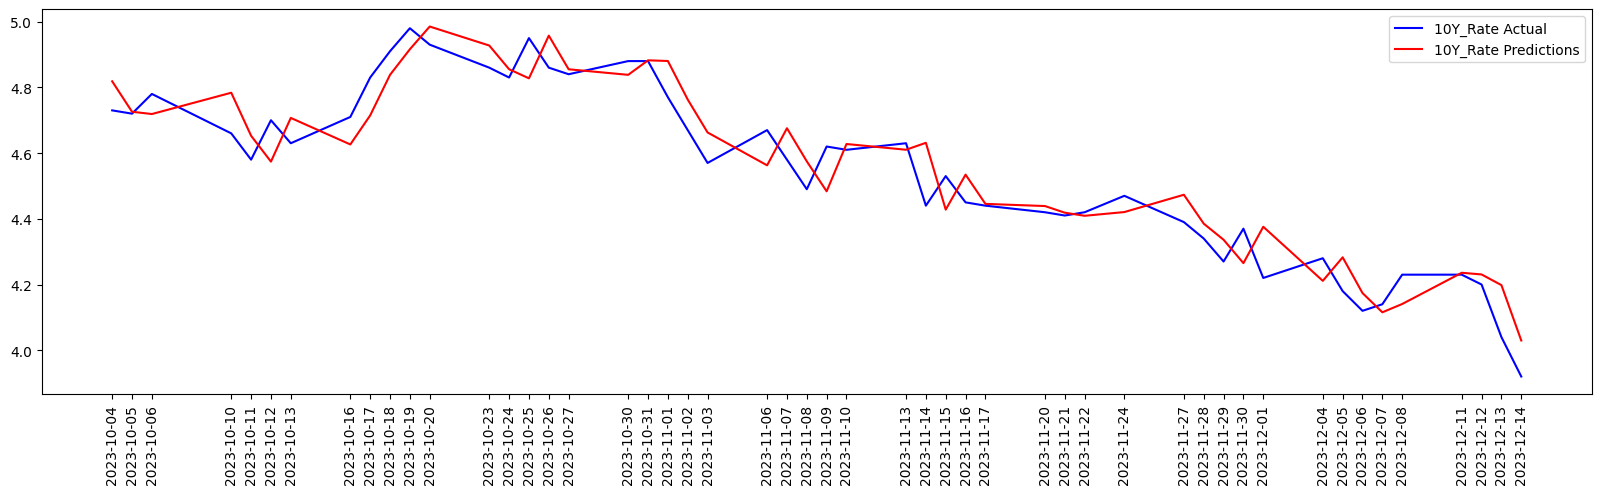

Test RMSE: 0.08549
Total time: 87.89307236671448 seconds


In [26]:
# Walk-forward validation to evaluate ARIMA model
start = time.time()

X = predict_10Y_Rate
size = len(X[:-50])
train, test = X[:size], X[size:]
history = [x for x in train]
predictions = list()
len(test)

for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1), trend='n')
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print( ' predicted=%f, expected=%f ' % (yhat, obs))

# Evaluate forecasts
plt.figure(figsize=(20,5))
plt.plot(test.index, test, color='blue')
plt.plot(test.index, predictions, color='red')
plt.legend(('10Y_Rate Actual', '10Y_Rate Predictions'))
plt.xticks(test.index, rotation=90)
plt.show()

rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.5f' % rmse)

end = time.time()
print("Total time:", end-start, "seconds")

Base model has RMSE output of 0.08549. On average, there is an error of 0.08549 units when comparing prediction against actual values. We will use this as the benchmark for advanced modelling techniques in the next section.